In [19]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
print(__doc__)

import numpy as np
from matplotlib import pyplot as plt

from crawlab_toolbox import plotting

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow import keras
assert tf.__version__ >= "2.0"

gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)


Automatically created module for IPython interactive environment


In [10]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [22]:
pca = PCA()

In [23]:
X_transformed = pca.fit_transform(X)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

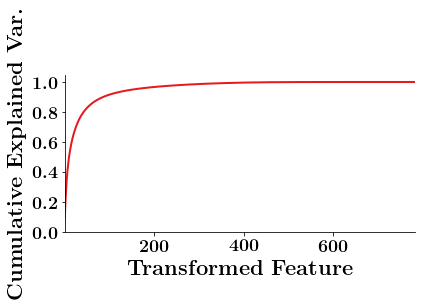

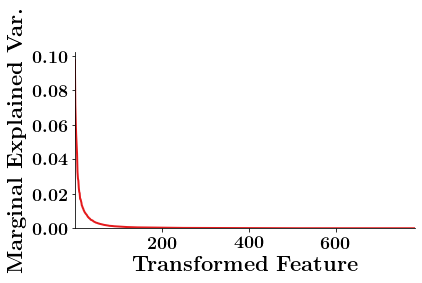

In [24]:

# responses = np.vstack((raw_fft.real,raw_fft.imag,(raw_fft * raw_fft.conj()).real))
responses = np.vstack((cumulative_variance))
plotting.generate_plot(np.arange(cumulative_variance.shape[0]),responses,
                         [''],'Transformed Feature','Cumulative Explained Var.',showplot=True,
                         template='publication',
                         ymax=0.05,
                         save_plot=True,
                         transparent=True,
                         num_col=2,
                         folder='figures/',
                         filename='Cumulative_Explained_Variance',
                         file_type='png')

responses = np.vstack((pca.explained_variance_ratio_))
plotting.generate_plot(np.arange(cumulative_variance.shape[0]),responses,
                         [''],'Transformed Feature','Marginal Explained Var.',showplot=True,
                         template='publication',
                         ymax=0.05,
                         save_plot=True,
                         transparent=True,
                         num_col=2,
                         folder='figures/',
                         filename='Marginal_Explained_Variance',
                         file_type='png')



In [25]:
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X)
X_recovered = pca.inverse_transform(X_reduced)

In [26]:
import matplotlib as mpl

def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

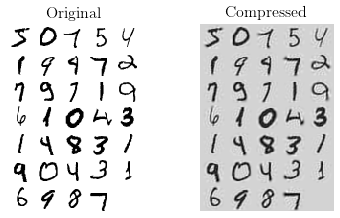

In [27]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

plt.savefig("figures/PCA_Compression.png")

In [32]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [33]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 
    
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=[X_test, X_test])

Train on 55000 samples, validate on 10000 samples
Epoch 1/25
55000/55000 [==============================] - 3s 59us/sample - loss: 0.3902 - rounded_accuracy: 0.8604 - val_loss: 0.3602 - val_rounded_accuracy: 0.8834
Epoch 2/25
55000/55000 [==============================] - 2s 40us/sample - loss: 0.3425 - rounded_accuracy: 0.8982 - val_loss: 0.3396 - val_rounded_accuracy: 0.8972
Epoch 3/25
55000/55000 [==============================] - 2s 40us/sample - loss: 0.3328 - rounded_accuracy: 0.9053 - val_loss: 0.3322 - val_rounded_accuracy: 0.9076
Epoch 4/25
55000/55000 [==============================] - 2s 40us/sample - loss: 0.3276 - rounded_accuracy: 0.9093 - val_loss: 0.3259 - val_rounded_accuracy: 0.9124
Epoch 5/25
55000/55000 [==============================] - 2s 40us/sample - loss: 0.3245 - rounded_accuracy: 0.9120 - val_loss: 0.3288 - val_rounded_accuracy: 0.9120
Epoch 6/25
55000/55000 [==============================] - 2s 41us/sample - loss: 0.3223 - rounded_accuracy: 0.9137 - val_loss

In [30]:
X_test.shape

(14000, 784)

In [31]:
variational_ae.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
model_9 (Model)                 [(None, 10), (None,  134870      input_7[0][0]                    
__________________________________________________________________________________________________
model_10 (Model)                (None, 28, 28)       134634      model_9[1][2]                    
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 784)          0           input_7[0][0]                    
___________________________________________________________________________________________

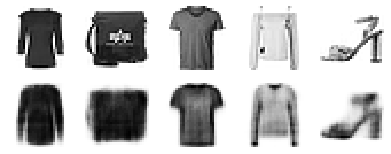

In [36]:

def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

show_reconstructions(variational_ae)
plt.show()